# Prevendo roubo de celulares em SP

## Baixando biblioteca necessária
`pip install xlwt`

`conda install xlwt`

`conda install xlrd`

`conda install plotly`

`conda install matplotlib`

`pip install squarify`

### Importando bibliotecas Pandas e Numpy

In [1]:
import pandas as pd
import numpy as np
import glob  
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt               # Visualização de dados
import matplotlib
plt.style.use('fivethirtyeight') 
import squarify
# pd.set_option('mode.chained_assignment, None)      ##Eliminando warnings

### Abrindo arquivo XLS disponível no SSP-SP

#### Os arquivos possuem um erro, sendo impossível abrir o arquivo
*XLRDError: Unsupported format, or corrupt file: Expected BOF record; found b'A\x00N\x00O\x00_\x00'*

A solução foi encontrada nesse artigo do [Medium](https://medium.com/@jerilkuriakose/recover-corrupt-excel-file-xls-or-xlsx-using-python-2eea6bb07aae)

#### Apenas para resolver o problema de formato
Você pode até salvar o arquivo como .csv, mas a leitura pode informar algum erro

In [2]:
from __future__ import unicode_literals
# Used to save the file as excel workbook
# Need to install this library
from xlwt import Workbook
# Used to open to corrupt excel file
import io

filename = 'DadosBO_2020_8.xls'
# Opening the file using 'utf-16' encoding
file = io.open(filename, "r", encoding="utf-16-le")
data = file.readlines()

# Creating a workbook object
xldoc = Workbook()
# Adding a sheet to the workbook object
sheet = xldoc.add_sheet("Sheet1", cell_overwrite_ok=True)
# Iterating and saving the data to sheet
for i, row in enumerate(data):
    # Two things are done here
    # Removeing the '\n' which comes while reading the file using io.open
    # Getting the values after splitting using '\t'
    for j, val in enumerate(row.replace('\n', '').split('\t')):
        sheet.write(i, j, val)
    
# Saving the file as an excel file
xldoc.save('file.xls')

In [3]:
#dataset = pd.read_excel("DadosBO_2020_7.xls", engine='xlrd')
columns = ['ANO_BO', 'NUM_BO', 'BO_INICIADO', 'BO_EMITIDO', 'DATAOCORRENCIA', 'HORAOCORRENCIA', 'PERIDOOCORRENCIA', 'DATACOMUNICACAO', 'DATAELABORACAO', 'BO_AUTORIA', 'FLAGRANTE', 'LOGRADOURO', 'NUMERO', 'BAIRRO', 'CIDADE', 'UF', 'LATITUDE', 'LONGITUDE', 'DESCRICAOLOCAL', 'SOLUCAO', 'DELEGACIA_NOME', 'DELEGACIA_CIRCUNSCRICAO', 'ESPECIE', 'RUBRICA', 'DESDOBRAMENTO', 'STATUS', 'QUANT_CELULAR', 'MARCA_CELULAR','DESCR_TIPO_VEICULO']

column_dates = ['BO_INICIADO', 'BO_EMITIDO', 'DATAOCORRENCIA', 'HORAOCORRENCIA','DATACOMUNICACAO', 'DATAELABORACAO']

dtypes = {
    'ANO_BO': np.int32,
    'NUM_BO': np.int64,
    'QUANT_CELULAR': pd.Int16Dtype(),
    'LATITUDE': np.float32,
    'LONGITUDE': np.float32 
}

dataset = pd.read_excel("file.xls", parse_dates=column_dates, usecols=columns, dtype=dtypes, thousands=',')

# ==========================================================
# Aqui vai a leitura via CSV

In [49]:
# FUNÇÃO PARA IMPORTAR DATASET

dir_path = "data/"

def importaData(files):
    
    data = dir_path + files
    allFiles = glob.glob('data/*.csv')
    list_ = []
    cols = ['ANO_BO', 'DATAOCORRENCIA', 'PERIDOOCORRENCIA', 'BAIRRO', 'CIDADE', 'LATITUDE', 'LONGITUDE', 'LOGRADOURO', \
           'DESCRICAOLOCAL', 'DESCR_TIPO_VEICULO', 'QUANT_CELULAR']

    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0, delimiter=';', usecols=cols)
        list_.append(df)

    df = pd.concat(list_, axis = 0, ignore_index = True)
    return df

# IMPORTANDO DATASET

dataset = importaData('*.csv')

C:\Users\marco\miniconda3\envs\teste\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning:

Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.



In [50]:
# REMOVENDO DADOS DUPLICADOS

def removeDuplicados(df):
    df.drop_duplicates(inplace=True)
    return df

dataset = removeDuplicados(dataset)

In [51]:
# FILTRANDO DADOS DE S.PAULO

def filtraSP(df):
    df.CIDADE.fillna('S.PAULO')
    df = df[df['CIDADE'] == 'S.PAULO']
    del df['CIDADE']
    return df

dataset = filtraSP(dataset)

In [52]:
# TRANSFORMANDO STRINGS PARA LOWER CASE

def lowerCase(df, cols):
    for col in cols:
        df[col] = df[col].str.title()
    return df

colsToLower = ["PERIDOOCORRENCIA", "LOGRADOURO", "BAIRRO", "DESCR_TIPO_VEICULO"]
dataset = lowerCase(dataset, colsToLower)

In [53]:
# PADRONIZANDO STRINGS

def correct_string(string):
        string = string.replace('Avenida ', 'Av. ').replace('Av ', 'Av. ').replace('Rua ', 'R. ').replace('R ', 'R. ') \
                    .replace('R ', 'R. ').replace(',', '.').replace('Praça ', 'Pr. ').replace('Pr ', 'Pr. ').replace('Pública', 'pública')
        return string

dataset.DESCRICAOLOCAL = dataset.astype(str).DESCRICAOLOCAL.apply(correct_string)    
dataset.LOGRADOURO = dataset.astype(str).LOGRADOURO.apply(correct_string)
dataset.LATITUDE = dataset.LATITUDE.astype(str).apply(correct_string).astype(float)
dataset.LONGITUDE = dataset.LONGITUDE.astype(str).apply(correct_string).astype(float)


In [57]:
# TRANSFORMANDO DADOS TEMPORAIS

def tratarDatas(df, col = 'DATAOCORRENCIA'):
    df[col] = pd.to_datetime(df[col], format='%d/%m/%Y', errors='coerce')
    indexs = []
    for row in df[col].items():
        if row[1] < pd.datetime(2010, 1, 1):
            indexs.append(row[0])
    df.drop(index=indexs, axis=1, inplace=True)
    df['diasemana'] = df[col].dt.day_name()
    df['mesano'] = df[col].dt.strftime('%Y-%m')
    df['ano'] = df[col].dt.strftime('%Y')
    df['mes'] = df[col].dt.month
    df.drop(index=df[df['mesano'] == 'NaT'].index, inplace=True, axis=0)
    return df
    
dataset = tratarDatas(dataset)

<ipython-input-57-d94626a69c9f>:7: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



# ==========================================================

In [58]:
dataset

,ANO_BO,DATAOCORRENCIA,PERIDOOCORRENCIA,LOGRADOURO,BAIRRO,LATITUDE,LONGITUDE,DESCRICAOLOCAL,DESCR_TIPO_VEICULO,QUANT_CELULAR,diasemana,mesano,mes,ano
4,2010,2010-01-01,De Madrugada,R. Da Consolacao,NaN,NaN,NaN,Via pública,NaN,1,Friday,2010-01,1.0,2010
8,2010,2010-01-01,Pela Manhã,Est Das Lagrimas,Sao Joao Climaco,NaN,NaN,Via pública,NaN,1,Friday,2010-01,1.0,2010
13,2010,2010-01-01,Pela Manhã,R. Pedro Soares De Andrade,Sao Miguel Paulista,NaN,NaN,Via pública,NaN,2,Friday,2010-01,1.0,2010
24,2010,2010-01-01,Pela Manhã,Largo Ubirajara,Mooca,NaN,NaN,Via pública,NaN,1,Friday,2010-01,1.0,2010
29,2010,2010-01-01,Pela Manhã,R. Jerico,Vila Madalena,NaN,NaN,Via pública,NaN,1,Friday,2010-01,1.0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304697,2018,2018-09-30,A Noite,Av. Deputado Cantidio Sampaio,Brasilandia,-23.457706,-46.690668,Via pública,NaN,1,Sunday,2018-09,9.0,2018
1304699,2018,2018-09-29,A Tarde,R. Rainha Das Missoes,Cidade Ademar,-23.685558,-46.648486,Via pública,NaN,NaN,Saturday,2018-09,9.0,2018
1304700,2018,2018-09-30,A Noite,Av. Dos Funcionarios Publicos,Jardim Angela,-23.746413,-46.769657,Via pública,NaN,1,Sunday,2018-09,9.0,2018
1304701,2018,2018-09-30,A Noite,R. Jorge Newbery,Jacana,-23.480309,-46.565812,Via pública,Motociclo,1,Sunday,2018-09,9.0,2018


In [59]:
dataset.dtypes

ANO_BO                        object
DATAOCORRENCIA        datetime64[ns]
PERIDOOCORRENCIA              object
LOGRADOURO                    object
BAIRRO                        object
LATITUDE                     float64
LONGITUDE                    float64
DESCRICAOLOCAL                object
DESCR_TIPO_VEICULO            object
QUANT_CELULAR                 object
diasemana                     object
mesano                        object
mes                          float64
ano                           object
dtype: object

In [ ]:
#max(dataset.NUMERO)

#### Capturando nome das colunas importantes no dataset

In [7]:
string_gerada=""
for item in dataset.columns:
    string_gerada += "'"+item+"'"+", "
string_gerada

"'ANO_BO', 'NUM_BO', 'BO_INICIADO', 'BO_EMITIDO', 'DATAOCORRENCIA', 'HORAOCORRENCIA', 'PERIDOOCORRENCIA', 'DATACOMUNICACAO', 'DATAELABORACAO', 'BO_AUTORIA', 'FLAGRANTE', 'LOGRADOURO', 'NUMERO', 'BAIRRO', 'CIDADE', 'UF', 'LATITUDE', 'LONGITUDE', 'DESCRICAOLOCAL', 'SOLUCAO', 'DELEGACIA_NOME', 'DELEGACIA_CIRCUNSCRICAO', 'ESPECIE', 'RUBRICA', 'DESDOBRAMENTO', 'STATUS', 'DESCR_TIPO_VEICULO', 'QUANT_CELULAR', 'MARCA_CELULAR', "

In [8]:
drop_c = ['ANO_BO', 'NUM_BO', 'BO_INICIADO', 'BO_EMITIDO', 'DATAOCORRENCIA', 'HORAOCORRENCIA', 'PERIDOOCORRENCIA', 'DATACOMUNICACAO', 'DATAELABORACAO', 'BO_AUTORIA', 'FLAGRANTE', 'LOGRADOURO', 'NUMERO', 'BAIRRO', 'CIDADE', 'UF', 'LATITUDE', 'LONGITUDE', 'DESCRICAOLOCAL', 'SOLUCAO', 'DELEGACIA_NOME', 'DELEGACIA_CIRCUNSCRICAO', 'ESPECIE', 'RUBRICA', 'DESDOBRAMENTO', 'STATUS', 'QUANT_CELULAR', 'MARCA_CELULAR']

In [9]:
string_gerada=[]
for item in dataset.columns:
    string_gerada.append(item)
string_gerada

['ANO_BO',
 'NUM_BO',
 'BO_INICIADO',
 'BO_EMITIDO',
 'DATAOCORRENCIA',
 'HORAOCORRENCIA',
 'PERIDOOCORRENCIA',
 'DATACOMUNICACAO',
 'DATAELABORACAO',
 'BO_AUTORIA',
 'FLAGRANTE',
 'LOGRADOURO',
 'NUMERO',
 'BAIRRO',
 'CIDADE',
 'UF',
 'LATITUDE',
 'LONGITUDE',
 'DESCRICAOLOCAL',
 'SOLUCAO',
 'DELEGACIA_NOME',
 'DELEGACIA_CIRCUNSCRICAO',
 'ESPECIE',
 'RUBRICA',
 'DESDOBRAMENTO',
 'STATUS',
 'DESCR_TIPO_VEICULO',
 'QUANT_CELULAR',
 'MARCA_CELULAR']

In [10]:
columns = ['NUMERO_BOLETIM', 'NUMERO_BOLETIM_PRINCIPAL', 'EXAME', 'NOMEPESSOA', 'TIPOPESSOA', 'VITIMAFATAL', 'RG', 'RG_UF', 'NATURALIDADE', 'NACIONALIDADE', 'SEXO', 'DATANASCIMENTO', 'IDADE', 'ESTADOCIVIL', 'PROFISSAO', 'GRAUINSTRUCAO', 'CORCUTIS', 'NATUREZAVINCULADA', 'TIPOVINCULO', 'RELACIONAMENTO', 'PARENTESCO', 'PLACA_VEICULO', 'UF_VEICULO', 'CIDADE_VEICULO', 'DESCR_COR_VEICULO', 'DESCR_MARCA_VEICULO', 'ANO_FABRICACAO', 'ANO_MODELO', 'DESCR_TIPO_VEICULO']

In [11]:
dataset['PERIDOOCORRENCIA'].str.title()

0        Pela Manhã
1           A Tarde
2           A Tarde
3           A Noite
4           A Noite
            ...    
13527       A Noite
13528       A Noite
13529       A Tarde
13530       A Noite
13531    Pela Manhã
Name: PERIDOOCORRENCIA, Length: 13532, dtype: object

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html


In [12]:
'======================================================================='

'======================================================================='

In [ ]:
ocorrencias = dataset.groupby('mesano').count()['ANO_BO'].reset_index()
ocorrencias.rename(columns={'mesano': 'Data', 'ANO_BO':'Ocorrências de Roubo de Celular'}, inplace=True)

trace = [go.Scatter(x = ocorrencias.Data, y = ocorrencias['Ocorrências de Roubo de Celular'])]

layout = dict(
    title='Ocorrências de Roubo de Celular por Mês',
    yaxis=dict(
    title='Ocorrências'
    ),
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=12,
                     label='1yr',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=trace, layout=layout)
py.iplot(fig)

In [26]:
# CALCULANDO VARIAÇÕES NO NÚMERO DE OCORRÊNCIAS POR ANO

dataset.ANO_BO = dataset.ANO_BO.astype(int)
ocorrencias_ano = dataset.groupby('ANO_BO').count()['DATAOCORRENCIA'].reset_index()
ocorrencias_ano['VARIACAO'] = 0
ocorrencias_ano['VARIACAO_ACUMULADA'] = 0


C:\Users\marco\miniconda3\envs\teste\lib\site-packages\pandas\core\generic.py:5165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
ocorrencias_ano
#so ta retornando uma linha porque só tem info de 2020 basicamente
#mudar o i do for abaixo de acordo com a quantidade de linhas de ocorrencias_ano

In [28]:
for i in range (0, 8):
    ocorrencias_ano.iloc[i+1, 2] = round((1 - (ocorrencias_ano.iloc[i, 1] / ocorrencias_ano.iloc[i+1, 1])) * 100, 2)
    ocorrencias_ano.iloc[i+1, 3] = round((ocorrencias_ano.iloc[i, 3] + ocorrencias_ano.iloc[i+1, 2]), 2)
    
ocorrencias_ano.VARIACAO = ocorrencias_ano.VARIACAO.astype(str) + ' %'
ocorrencias_ano.VARIACAO_ACUMULADA = ocorrencias_ano.VARIACAO_ACUMULADA.astype(str) + ' %'

data = [
    go.Bar(
        x = ocorrencias_ano.ANO_BO.values[1:],
        y = ocorrencias_ano.VARIACAO.values[1:],
        marker = dict(
          color = ['green', 'green', 'green', 'green', 'red', 'green', 'red', 'red']
        ),
        name = 'Variação anual'
    ), 
    go.Scatter(
        x = ocorrencias_ano.ANO_BO.values[1:], 
        y = ocorrencias_ano.VARIACAO_ACUMULADA.values[1:],
        marker = dict(
          color = 'blue'
        ),        
        name = 'Variação acumulada'
    )
]

layout = dict(
    title='Variação do Número de Ocorrências de Roubo de Celular',
    yaxis=dict(
        title='Variação (%)',
        ),
    )

fig = dict(data=data, layout=layout)
py.iplot(fig)

In [29]:
dataset['diasemana'] = pd.Categorical(dataset['diasemana'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered=True)

trace = [go.Bar(
            x = dataset['diasemana'].value_counts().sort_index().index,
            y = dataset['diasemana'].value_counts().sort_index().values,
            textposition = 'auto',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1,
                    )
                ),
            opacity=0.8
)]
           
layout = go.Layout(
    title='Ocorrências de Roubo de Celular por Dia da Semana (2020)',
    yaxis=dict(
        title='Ocorrências'
        ),
)

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig)

<ipython-input-29-9340043d4231>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
colors = ['#170B3B', '#A9D0F5', '#08088A', '#DBA901']

trace = [go.Pie(labels=dataset.PERIDOOCORRENCIA.unique(), values=dataset.PERIDOOCORRENCIA.value_counts().values,
               hoverinfo='label+percent', 
               textfont=dict(size=18),
               marker=dict(colors=colors, 
                           line=dict(color='#000000', width=2)))]

layout = go.Layout(
    title='Período das Ocorrências de Roubo de Celular (2010-2018)'
)

fig = go.Figure(data = trace, layout = layout)

py.iplot(fig)

In [35]:
# FILTRANDO DADOS DE 2018

data = dataset[dataset["ANO_BO"] == 2018].copy()

# PLOT

trace = [go.Bar(
            y = data['DESCRICAOLOCAL'].value_counts().index,
            x = data['DESCRICAOLOCAL'].value_counts().values,
            orientation='h',
            textposition = 'auto',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1,
                    )
                ),
            opacity=0.8
)]
           
layout = go.Layout(
    height=800,
    title='Locais das Ocorrências de Roubo de Celular em 2018',
    xaxis=dict(
        title = 'Ocorrências',
        type='log',
        ),
     yaxis=go.layout.YAxis(
     automargin=True
     )
)

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig)

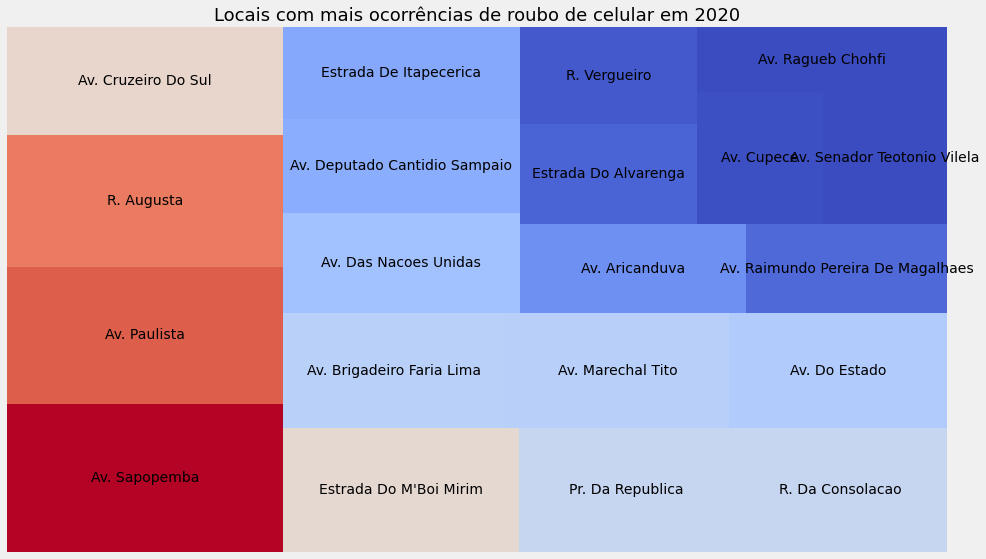

In [33]:
fig, ax = plt.subplots(figsize=(15,9))

cmap = matplotlib.cm.coolwarm
mini = data.LOGRADOURO.value_counts().values[19]
maxi = data.LOGRADOURO.value_counts().values[0]
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in data.LOGRADOURO.value_counts().iloc[:100].values]

squarify.plot(sizes=data.LOGRADOURO.value_counts().iloc[:20].values, label=data.LOGRADOURO.value_counts().iloc[:20].index, color=colors)

plt.axis('off')
plt.title("Locais com mais ocorrências de roubo de celular em 2020", fontsize=18)
ttl = ax.title
ttl.set_position([.5, 1.05])

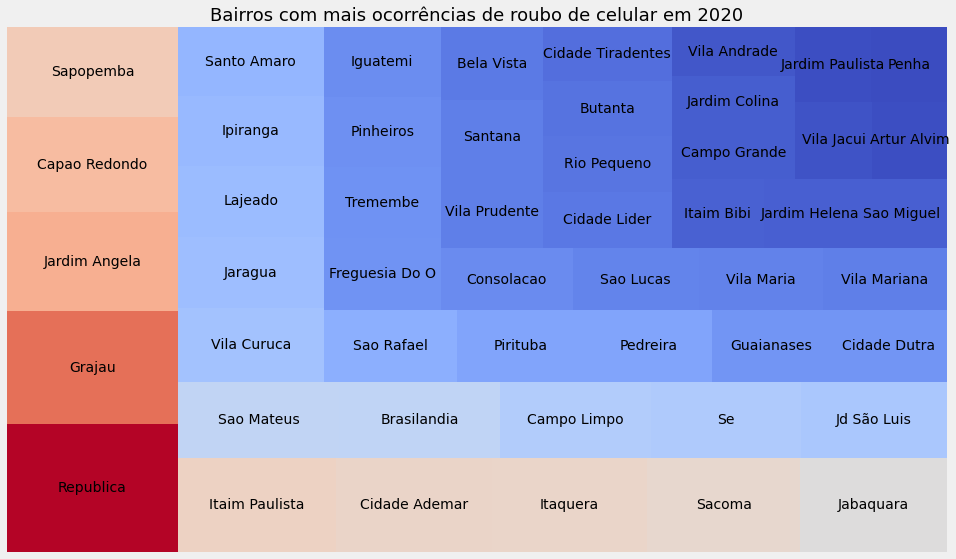

In [34]:
fig, ax = plt.subplots(figsize=(15,9))

cmap = matplotlib.cm.coolwarm
mini = data.BAIRRO.value_counts().values[49]
maxi = data.BAIRRO.value_counts().values[0]
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in data.BAIRRO.value_counts().iloc[:100].values]

squarify.plot(sizes=data.BAIRRO.value_counts().iloc[:50].values, label=data.BAIRRO.value_counts().iloc[:50].index, color=colors)

plt.axis('off')
plt.title("Bairros com mais ocorrências de roubo de celular em 2020", fontsize=18)
ttl = ax.title
ttl.set_position([.5, 1.05])

In [48]:
# FILTRANDO DADOS DE 2018

data = dataset.copy()

# PLOT

trace = [go.Bar(
            y = data['DESCR_TIPO_VEICULO'].value_counts().index,
            x = data['DESCR_TIPO_VEICULO'].value_counts().values,
            orientation='h',
            textposition = 'auto',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1,
                    )
                ),
            opacity=0.8
)]
           
layout = go.Layout(
    height=800,
    title='Veículos mais visados pelos ladrões para roubar um celular(2010-2018)',
    xaxis=dict(
        title = 'Ocorrências',
        type='log',
        ),
     yaxis=go.layout.YAxis(
     automargin=True
     )
)

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig)

In [66]:
dataset['ano'] = pd.Categorical(dataset['ano'], categories=['2010','2011','2012','2013','2014','2015', '2016', '2017', '2018'], ordered=True)

trace = [go.Bar(
            x = dataset['ano'].value_counts().sort_index().index,
            y = dataset['QUANT_CELULAR'].value_counts(),
            textposition = 'auto',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1,
                    )
                ),
            opacity=0.8
)]
           
layout = go.Layout(
    title='Ocorrências de Roubo de Celular por Dia da Semana (2020)',
    yaxis=dict(
        title='Ocorrências'
        ),
)

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig)

In [67]:
dataset['ano']

4          2010
8          2010
13         2010
24         2010
29         2010
           ... 
1304697    2018
1304699    2018
1304700    2018
1304701    2018
1304702    2018
Name: ano, Length: 924651, dtype: category
Categories (9, object): ['2010' < '2011' < '2012' < '2013' ... '2015' < '2016' < '2017' < '2018']

In [98]:
qnt_ano = dataset.groupby('ANO_BO').count()['QUANT_CELULAR'].reset_index()

In [101]:
qnt_ano

,ANO_BO,QUANT_CELULAR
0,2010,42788
1,2011,51150
2,2012,53363
3,2013,70248
4,2014,92905
5,2015,87639
6,2016,105616
7,2017,109398
8,2018,97102
9,2010,3819


In [103]:
trace = [go.Bar(
            x = qnt_ano['ANO_BO'],
            y = qnt_ano['QUANT_CELULAR'],
            textposition = 'auto',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1,
                    )
                ),
            opacity=0.8
)]
           
layout = go.Layout(
    title='Quantidade de celulares roubados (2010-2018)',
    yaxis=dict(
        title='Qnt. cel'
        ),
)

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig)